## House price prediction with Concrete ML XGBoost Regressor

The XGBoost (Extreme Gradient Boosting) algorithm is one of the most popular algorithms in ML and often the big winner in various kaggle competitions.

XGBoost is a supervised machine learning algorithm, which attempts to accurately predict a target variable by combining the estimates of a set of simpler and weaker models.

In this notebook, we tackle a privacy-preserving regression task with the XGBoost model from Concrete ML. The data-set used is "Housing prices", which contains real-world data.

This tutorial shows how to use XGBoost regression with Concrete ML and discusses model parameter choices that enable efficient privacy-preserving inference using FHE.

Let's get started.

### Import libraries

First, import the required packages, the classical XGBoost regressor and its Concrete ML counterpart.

In [1]:
# pylint: disable=too-many-lines,invalid-name
import warnings

# For warnings in xgboost.sklearn
warnings.simplefilter(action="ignore", category=FutureWarning)

import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics, preprocessing
from sklearn.datasets import fetch_openml
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost.sklearn import XGBRegressor as SklearnXGBRegressor

from concrete.ml.sklearn import XGBRegressor as ConcreteXGBRegressor

## Data-set 

Let's download the data-set from [openml](https://www.openml.org/search?type=data&status=active&id=43926).

The goal is to estimate the selling price of houses based on 81 features.

In [2]:
# Fetch the ames_housing data-set from openml using its data_id.
df, y = fetch_openml(data_id=43926, return_X_y=True)

# Add the target column to the other features.
df.insert(0, y.name, y)
print(f"Shape: {df.shape}")

df.head(2)

Shape: (2930, 81)


,Sale_Price,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Longitude,Latitude
0,215000.0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,...,No_Pool,No_Fence,None,0.0,5.0,2010.0,WD,Normal,-93.619754,42.054035
1,105000.0,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,...,No_Pool,Minimum_Privacy,None,0.0,6.0,2010.0,WD,Normal,-93.619756,42.053014


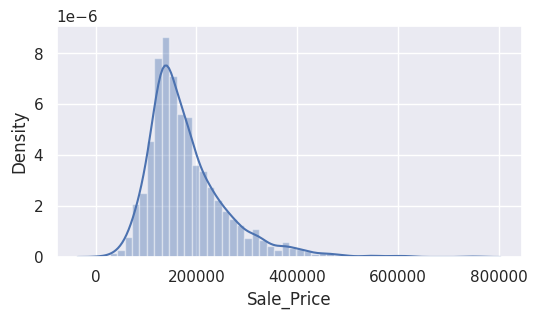

In [3]:
# Check the target distribution.
sns.set(rc={"figure.figsize": (6, 3)})
sns.distplot(y);

In [4]:
# Pick the numerical features of our data-set.
float_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns = df.select_dtypes(include="category").columns

print(
    f"{len(float_columns)} numerical features vs {len(categorical_columns)} categorical features."
)

35 numerical features vs 46 categorical features.


This data-set is composed of $35$ numerical variables and $46$ categorical variables (which represent more than half of the features in our data-set). We can also note that the features are not in the same scale.

### Pre-processing

Unlike linear models, decision trees require less data processing. Cases of missing values and outliers have less impact as tree models are not distance based, so they can handle varying ranges of features. Thus, there is no need for feature scaling (standardization or normalization). Moreover, tree-based models can handle categorical variables.

However, we cannot apply our trees directly on categorical data. To convert these variables into numerical form, there are several approaches:

**One Hot Encoding:** 

A binary representation, that creates $k-1$ additional dummy variables (DVs) where $k$ is the number of different values that the categorical variable can take. 

But trees perform poorly with this type of encoding, if the number of variables is big, because DVs induce sparsity into the data-set (many zeros, few ones). In addition, since tree algorithms use splits based on feature values and all the dummy variables are independent, if the tree decides to make a split on one of the DVs, there is only one possible split. Thus, the trees will generally tend to grow in the direction of the zeros. The splits are not optimal and the resulting tree will perform badly.

**Label Encoding:**

Label Encoding converts each value in a categorical column to a number. The numbers are assigned in increasing order.

Label Encoding is most commonly used for categorical target variables that have some type of order in their values. 

When a large number of such categorical variables are present, and they have many unique values, in the case of tree-based models, Label Encoding of all categorical variables often provides a simple and sufficiently effective solution to encoding these values. 

Indeed with One Hot Encoding, the dimensionality of the data becomes too great and the resolution of one hot encoded variables is too low, as described above.

In the following, we use the label encoding approach.

In [5]:
df_encoded = df.copy()

# Encode target labels with value between 0 and n_classes-1.
le = preprocessing.LabelEncoder()
# Convert the above categorical features into numeric type.
df_encoded[categorical_columns] = df[categorical_columns].apply(le.fit_transform)

Let's see what the new dataframe looks like after LabelEncoding:  

In [6]:
# Before data transformation:
df[categorical_columns].head(2)

,MS_SubClass,MS_Zoning,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,...,Garage_Type,Garage_Finish,Garage_Qual,Garage_Cond,Paved_Drive,Pool_QC,Fence,Misc_Feature,Sale_Type,Sale_Condition
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,Gtl,North_Ames,...,Attchd,Fin,Typical,Typical,Partial_Pavement,No_Pool,No_Fence,None,WD,Normal
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,Gtl,North_Ames,...,Attchd,Unf,Typical,Typical,Paved,No_Pool,Minimum_Privacy,None,WD,Normal


In [7]:
# After data transformation:
df_encoded[categorical_columns].head(2)

,MS_SubClass,MS_Zoning,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,...,Garage_Type,Garage_Finish,Garage_Qual,Garage_Cond,Paved_Drive,Pool_QC,Fence,Misc_Feature,Sale_Type,Sale_Condition
0,2,5,1,1,3,3,0,0,0,15,...,0,0,5,5,1,3,4,2,9,4
1,2,4,1,1,2,3,0,4,0,15,...,0,3,5,5,2,3,2,2,9,4


Split the data into a training set and a test set.

In [8]:
# Removing the target column from the dataframe.
X = df_encoded.drop(columns=y.name, axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=True, random_state=24
)

## Baseline: a floating point clear-data XGB regressor

In [9]:
# Common hyper-parameters for both scikit-learn and Concrete ML.
n_estimators = 50
max_depth = 4
n_jobs = 1

Training and prediction with XGBoost

In [10]:
# 1. Instantiation of the model.
xgboost_reg = SklearnXGBRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=n_jobs)

# 2. Train the model.
xgboost_reg.fit(X_train, y_train)

# 3. XGBoost (fp32) predictions:
y_preds_XGBoost = xgboost_reg.predict(X_test)

# 4. Evaluation of the with r2_score metric.
print(f"R2_score with XGBoost: {metrics.r2_score(y_test, y_preds_XGBoost):.2f}")

R2_score with XGBoost: 0.92


## Concrete ML XGB regressor

The typical development flow of a Concrete ML model is the following:

1. The model is trained on clear (plaintext) data
    + Concrete ML currently only supports inference in FHE; training is done on clear data

2. Since FHE operates only over integers, the resulting trained model is quantized. To do so, you need to set `n_bits` parameter

    + note that the current version of Concrete ML has a precision limitation of 16-bits, i.e., it doesn't support encrypted values larger than 16-bits integers. So, if you encounter this error: `RuntimeError: Function you are trying to compile cannot be converted to MLIR` during compilation, decrease the number of bits.

3. The quantized model is compiled to an FHE equivalent. The compilation step can be broken up into 3 parts 
that are performed automatically by Concrete ML:

    + creation of an executable operation graph
    + checking that the operation graph is FHE compatible, i.e., checking the maximum bit-width needed to execute the model
    + determining cryptographic parameters that will help to generate the secret keys and evaluation keys

4. Once, the model is compiled to an FHE equivalent, inference can then be done on:
    + encrypted data, by setting `fhe` to `execute`
    + clear data, using the quantized model, by setting `fhe` to `disable`

In [11]:
# 1. Instantiation of the model, the only difference is the `n_bits` hyper-parameter.
# We quantize the inputs and the weights using `n_bits` because FHE operates only over integers

# n_bits is necessary for the XGBoost of Concrete ML.
n_bits = 5

concrete_reg = ConcreteXGBRegressor(
    n_bits=n_bits, n_estimators=n_estimators, max_depth=max_depth, n_jobs=n_jobs
)

# 2. We train the concrete XGBoost model on clear data.
concrete_reg.fit(X_train, y_train)

# 3. Compilation:
# The quantized model is compiled to an FHE equivalent. To do so, the compiler requires
# an exhaustive set of data to mainly evaluate the maximum integer bit-width within the graph,
# needed during the FHE computations.
circuit = concrete_reg.compile(X_train)
print(f"Generating a key for an {circuit.graph.maximum_integer_bit_width()}-bits circuit")

# Key generation:
# The compiler returns a circuit, which can then be used for the key generation.
time_begin = time.time()
circuit.client.keygen(force=False)
print(f"Key generation time: {(time.time() - time_begin):.3f} sec")

Generating a key for an 7-bits circuit
Key generation time: 0.412 sec


### Feature importances

An advantage of using decision trees is that once the trees are constructed, we can retrieve the importance scores of each attribute.

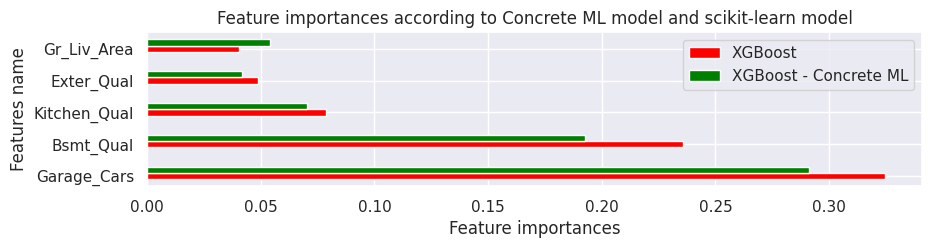

In [12]:
width = 0.2
n_features = 5  # or X.shape[1] to get all importance scores of each attributes
feature_names = X.columns

# Retrieving the feature importances.
concrete_feature_importances = concrete_reg.sklearn_model.feature_importances_
xgboost_feature_importances = xgboost_reg.feature_importances_

# Sorting the feature_importances_ according the XGBoost results.
index_importances = [[i, fi] for i, fi in enumerate(xgboost_feature_importances)]
index_importances_sorted = np.array(
    sorted(index_importances, key=lambda key: key[1], reverse=True)
)[:, 0]

# Displaying the 5 highest feature importances.
index_importances_sorted = list(map(int, index_importances_sorted))[:n_features]

_, ax = plt.subplots(figsize=(10, 2))

ax.barh(
    range(n_features),
    xgboost_feature_importances[index_importances_sorted],
    width,
    color="red",
    label="XGBoost",
)
ax.barh(
    np.arange(n_features) + width,
    concrete_feature_importances[index_importances_sorted],
    width,
    color="green",
    label="XGBoost - Concrete ML",
)

ax.set_title("Feature importances according to Concrete ML model and scikit-learn model", size=12)
ax.set_yticks(range(n_features), feature_names[index_importances_sorted][:n_features])
ax.set_xlabel("Feature importances")
ax.set_ylabel("Features name")

ax.legend(loc="best")
plt.show()

Both models give relatively the same importance scores.

### Inference with Concrete ML:

As mentioned above, you can perform inference in two ways :

a. __Simulation__: inference on clear data using Concrete ML, without secure FHE execution. 

b. __Execution in FHE__: inference on encrypted data, using FHE

### Simulation: inference on clear data

In [13]:
# 4.1 Inference on clear quantized data (fhe="disable"), the execution is very fast.
y_preds_non_fhe = concrete_reg.predict(X_test, fhe="disable")

Now, let's see the predictions of the quantized XGBoost model:

In [14]:
def plot_predictions(y_true: np.array, y_preds: dict, colors: list) -> None:
    # For a better visualization, we sort the predictions and the ground truth.
    y_true = np.array(y_true)
    idx = np.argsort(y_true)
    y_true_sorted = y_true[idx]

    for title, y_pred in y_preds.items():
        y_preds[title] = y_pred[idx].flatten()

    ncols, nrows = len(y_preds), 1

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5))

    for i, ((title, y_pred), c) in enumerate(zip(y_preds.items(), colors)):
        axes[i].scatter(np.arange(len(y_true_sorted)), y_true_sorted, c="r")
        axes[i].scatter(np.arange(len(y_true_sorted)), y_pred, c=c, alpha=0.5)
        axes[i].set_xlabel(title, labelpad=5)
        axes[i].set_ylabel("Sale_Prices ($)")
        # Hide x ticks, because it just refers to indexes.
        axes[i].get_xaxis().set_ticks([])

    # Set the spacing between subplots.
    fig.tight_layout()

R2_score with XGBoost: 0.9233
R2_score in FHE simulation (not encrypted): 0.8994


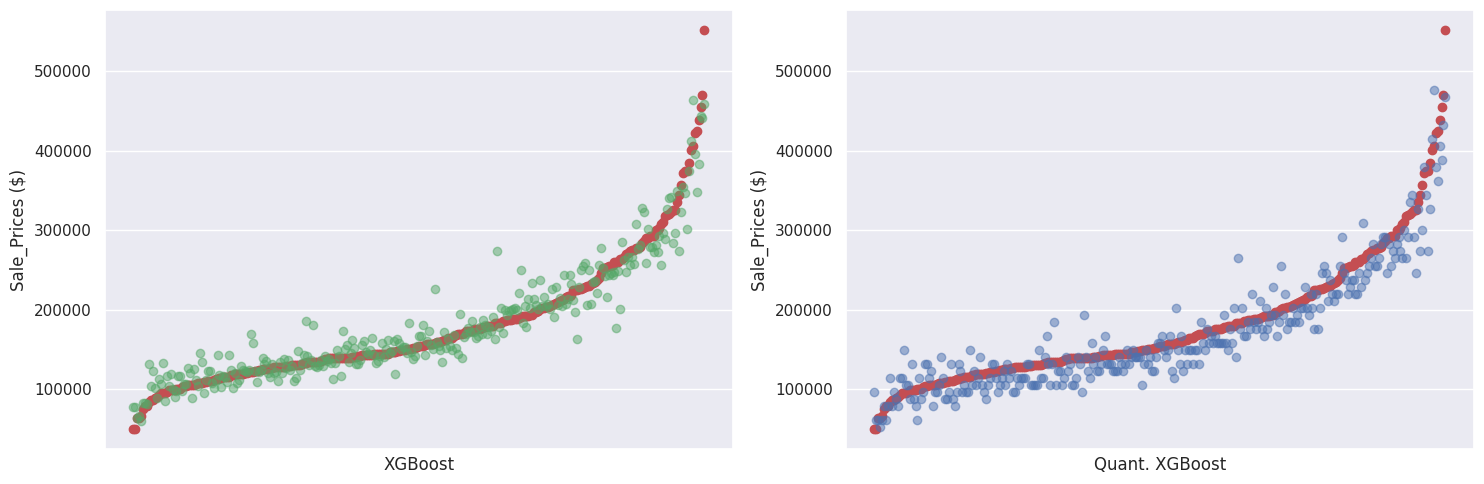

In [15]:
plot_predictions(
    y_test,
    y_preds={"XGBoost": y_preds_XGBoost, "Quant. XGBoost": y_preds_non_fhe},
    colors=["g", "b"],
)

print(f"R2_score with XGBoost: {metrics.r2_score(y_test, y_preds_XGBoost):.4f}")
print(
    f"R2_score in FHE simulation (not encrypted): {metrics.r2_score(y_test, y_preds_non_fhe):.4f}"
)

### Inference in FHE


### Model Design Space Exploration


Since the execution time in FHE can be long, a good practice is to find a good compromise between `n_estimators` and `n_bits` in order to obtain good performance while keeping these parameters low. The run-time of the XGB classifier
is strongly related to the values of these parameters (lower values give faster execution).

To find this parameter combination, grid search can be used using the sklearn `GridSearchCV` class.

In [16]:
n_folds = 5
param_grid = {
    "n_bits": [2, 3, 4, 5, 6, 7],
    "max_depth": [4],
    "n_estimators": [10, 20, 50, 100],
}

In [17]:
grid_search_concrete = GridSearchCV(ConcreteXGBRegressor(), param_grid, cv=n_folds, n_jobs=1)
grid_search_concrete.fit(X_train, y_train);

In [18]:
results = pd.DataFrame(grid_search_concrete.cv_results_)

print(f"Best score : {grid_search_concrete.best_score_:.3f}")
print(f"Best params: {grid_search_concrete.best_params_}")

Best score : 0.888
Best params: {'max_depth': 4, 'n_bits': 7, 'n_estimators': 50}


#### Impact of running in FHE:

In [19]:
def lineplot(df, yaxis, ylabel, title, group_keys: str = "param_n_estimators"):
    params = [
        {"color": "red", "linewidth": 1},
        {"color": "green", "marker": "x", "markersize": 5, "linewidth": 1},
        {"color": "magenta", "marker": "s", "markersize": 5, "dashes": (3, 20)},
        {"color": "blue", "marker": "^", "markersize": 5, "dashes": (3, 10)},
        {"color": "gold", "marker": "*", "markersize": 5, "dashes": (3, 40)},
        {"color": "black", "linestyle": "dashed", "dashes": (3, 10)},
    ]

    plt.figure(figsize=(15, 4))

    for (key, grp), param in zip(df.groupby([group_keys]), params):
        plt.plot(grp["param_n_bits"], grp[yaxis], **param, label=f"estimators_{key}")

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("$n_{bits}$")
    plt.legend(loc="best")
    plt.ylim(0, 1)
    plt.minorticks_on()
    plt.show()

Score according to n_bits, n_estimators and max_depth parameters:

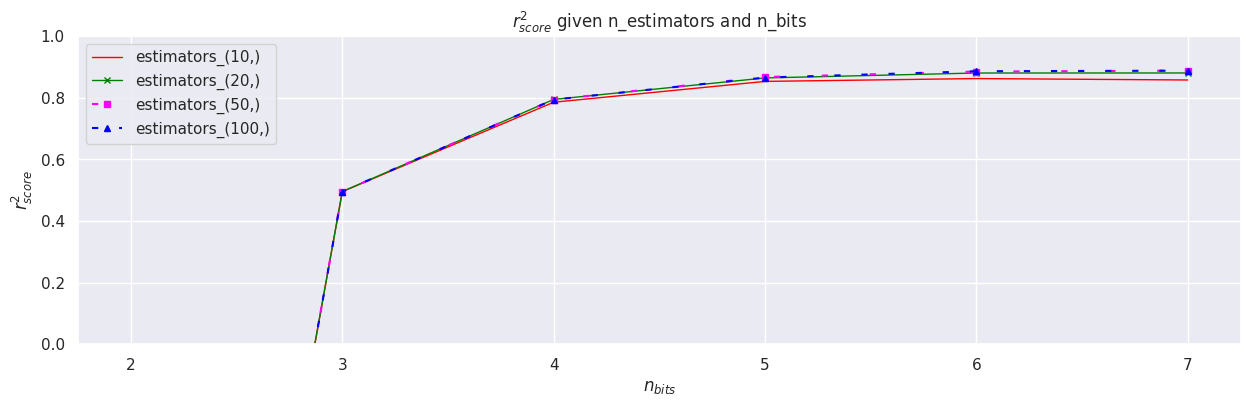

In [20]:
lineplot(
    df=results,
    yaxis="mean_test_score",
    ylabel="$r^2_{score}$",
    title="$r^2_{score}$ given n_estimators and n_bits",
)

Given a data-set of $2930$ examples and $81$ features.

As we can see in the graphs above: the higher the `n_bits` and `n_estimators`, the better the results. But the execution time also increases.
So, to keep this notebook fast, we manually choose the best combination of parameters: `n_estimators = 50, n_bits = 5`. Larger values for these parameters do not seem to provide a decrease in regression error (i.e., the R²_score does not increase). 

In [21]:
best_params_xgboost = {"n_estimators": 50, "n_bits": 5}

# Train the concrete xgboost with the best combination of parameters.
concrete_reg = ConcreteXGBRegressor(**best_params_xgboost, n_jobs=1)

concrete_reg.fit(X_train, y_train)

# Compile the model using the training data.
circuit = concrete_reg.compile(X_train)

# Get the equivalent predictions in clear quantized data:
y_preds_clear = concrete_reg.predict(X_test, fhe="disable")

# Perform the inference in FHE (simulation):
y_preds_simulated = concrete_reg.predict(X_test, fhe="simulate")

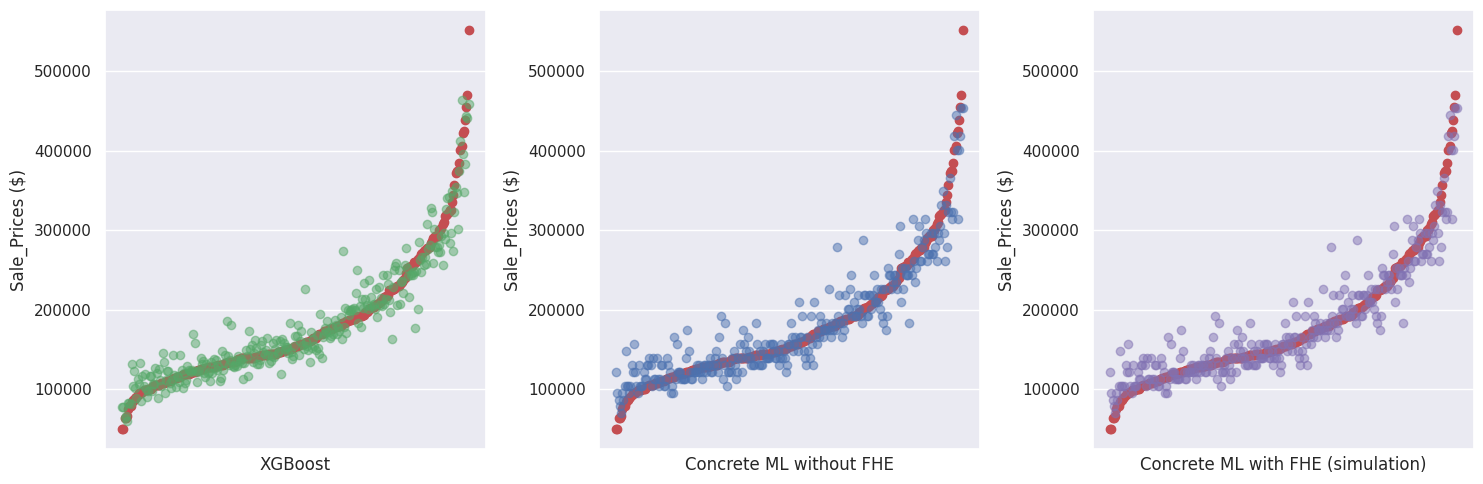

In [22]:
plot_predictions(
    y_test,
    y_preds={
        "XGBoost": y_preds_XGBoost,
        "Concrete ML without FHE": y_preds_clear,
        "Concrete ML with FHE (simulation)": y_preds_simulated,
    },
    colors=["g", "b", "m"],
)

In [23]:
# Test in FHE on a smaller test set
FHE_SAMPLE = 20
X_test_fhe = X_test[:FHE_SAMPLE]
y_test_fhe = y_test[:FHE_SAMPLE]

# Perform the inference in FHE:
time_begin = time.time()
y_preds_fhe = concrete_reg.predict(X_test_fhe, fhe="execute")
print(f"FHE runtime per sample: {(time.time() - time_begin) / len(X_test_fhe):.2f} sec")

FHE runtime per sample: 0.80 sec


In [24]:
# Evaluation

r2_score_sklearn = metrics.r2_score(y_test, y_preds_XGBoost)
r2_score_clear_concrete = metrics.r2_score(y_test, y_preds_clear)
r2_score_simulated_concrete = metrics.r2_score(y_test, y_preds_simulated)
r2_score_fhe_concrete = metrics.r2_score(y_test_fhe, y_preds_fhe)

print(f"R2_score with XGBoost            : {r2_score_sklearn:.4f}")
print(f"R2_score without FHE             : {r2_score_clear_concrete:.4f}")
print(f"R2_score with FHE (simulation)   : {r2_score_simulated_concrete:.4f}")
print(f"R2_score with FHE                : {r2_score_fhe_concrete:.4f}")

R2_score with XGBoost            : 0.9233
R2_score without FHE             : 0.9005
R2_score with FHE (simulation)   : 0.9005
R2_score with FHE                : 0.9036


As can be seen in this graph and in the R2 metric value, the predictions with and without an FHE execution are the same and the concrete XGBoost model is just as good as the XGBoost model (within a small error margin). 

### Conclusion

This tutorial, has shown how easy it is to build, train, and evaluate an XGBoost model using the Concrete ML library.

The results of the Concrete ML model are as good as those of the XGBoost model and execution in FHE is correct  with respect to the simulation results. 

The strong similarity between the XGBoost and Concrete ML was discussed and the tutorial presented the typical development flow of a Concrete ML model. 

The final regression model achieves an R2_score of $0.9$ and has a runtime on the order of several seconds.